In [154]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

In [155]:
import numpy as np

class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.5 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

In [156]:
# Load the data
data = pd.read_parquet('/Users/paddy/Documents/GitHub/Masterthesis_ML/data/03_032022_032023_taxi_rides.parquet')

# Convert the date column to datetime
data['date'] = pd.to_datetime(data['date'])



,date,count
0,2022-03-31 23:00:00+00:00,1
1,2022-04-01 00:00:00+00:00,26
2,2022-04-01 01:00:00+00:00,15
3,2022-04-01 02:00:00+00:00,5
4,2022-04-01 03:00:00+00:00,1


In [157]:
# Step 1: Data Preparation
# Extract features from the date
data['hour'] = data['date'].dt.hour
data['day_of_week'] = data['date'].dt.dayofweek
data['day_of_month'] = data['date'].dt.day
data['date_month'] = data['date'].dt.month
data['year'] = data['date'].dt.year


# Define the feature columns and the target column
feature_cols = ['hour', 'day_of_week', 'day_of_month', 'date_month', 'year']
target_col = 'count'

# Split the data: December 2022 as test data
train_data = data[data['date'] < '2023-02-01']
test_data = data[data['date'] >= '2023-02-01']

Blocked Cross Validation:
5-Folds

In [158]:

BCV = BlockingTimeSeriesSplit(n_splits=5)

In [159]:
# # Calculate the size of each block and the training and validation splits within each block
# block_size = len(train_data) // 5
# train_block = int(block_size * 0.75)
# val_block = block_size - train_block

In [160]:
# Initialize a linear regression model
lr = LinearRegression()

# Collecting all data list
data_list = []

# Lists to store the MSE for each blocked split
blocked_mse_list = []
blocked_rmse_list = []

In [166]:
# forschleife, um die 5 Blöcke zu durchlaufen
for train_block, val_block in BCV.split(train_data):
    # Split the data into training and validation sets
    train_fold, val_fold= train_data.loc[train_block], train_data.iloc[val_block]
    #val_fold = train_data.iloc[train_block:train_block + val_block]
    #train_block += block_size

    # Fit the model on the training data
    lr.fit(train_fold[feature_cols], train_fold[target_col])
    val_fold['prediction'] = lr.predict(val_fold[feature_cols])

    # #Writing all data into a list
    # data_list.append(val_fold)

    # Calculate the MSE and MAPE for this fold
    mse = mean_squared_error(val_fold[target_col], val_fold['prediction'])
    rmse = np.sqrt(mse)
    
    # Append the MSE to the list of MSEs
    blocked_mse_list.append(mse)
    blocked_rmse_list.append(rmse)



/var/folders/q3/tk8ksh9n6233c6nj3njq87x80000gn/T/ipykernel_6288/2306417320.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_fold['prediction'] = lr.predict(val_fold[feature_cols])
/var/folders/q3/tk8ksh9n6233c6nj3njq87x80000gn/T/ipykernel_6288/2306417320.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_fold['prediction'] = lr.predict(val_fold[feature_cols])
/var/folders/q3/tk8ksh9n6233c6nj3njq87x80000gn/T/ipykernel_6288/2306417320.py:11: SettingWithCopyWarning: 
A value is trying to be set o

Modelling the prediction model

In [162]:
# Calculate the average MSE for the blocked splits
average_mse_blocked = sum(blocked_mse_list) / len(blocked_mse_list)
average_mape_blocked = sum(blocked_rmse_list) / len(blocked_rmse_list)
#Ausage: MSE und MAPE für die 5 Blöcke
print(average_mse_blocked)
print(average_mape_blocked)



154.4433041923957
12.40775294840805


In [165]:
#predict the test data
test_data['prediction'] = lr.predict(test_data[feature_cols])

test_mse = mean_squared_error(test_data[target_col], test_data['prediction'])
test_rmse = np.sqrt(test_mse)
print(test_mse, test_rmse)


4665910070909604.0 68307467.16801615


/var/folders/q3/tk8ksh9n6233c6nj3njq87x80000gn/T/ipykernel_6288/2583424641.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['prediction'] = lr.predict(test_data[feature_cols])


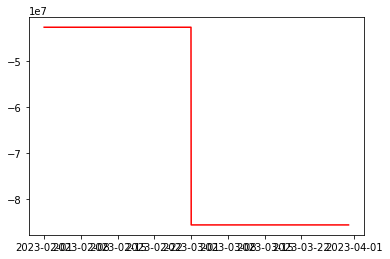

In [164]:
#plt.plot(test_data['date'], test_data['count'], label='actual', color='green')
plt.plot(test_data['date'], test_data['prediction'], label='prediction', color='red')